# Actividad 1: Deep Vision

En esta actividad, el alumno debe evaluar y comparar dos estrategias para la clasificación de imágenes en el dataset Caltech 101. El dataset ha sido preprocesado y guardado utilizando pickle (más información sobre el preprocesado se puede obtener en el notebook "preprocesado_caltech101" https://drive.google.com/open?id=1ioVl25t1p3mE2lTUFTwwOFi3fHFgUvtb).

Las instrucciones de cómo obtener el dataset aparecen al inicio de este notebook.

### Estrategia 1: Red pre-entrenada

La primera estrategia a comparar debe incluir la utilización de una red preentrenada con el dataset ImageNet, llevando a cabo tareas de *transfer learning* para clasificar los objetos de Caltech 101. Deben compararse al menos dos tipos de arquitecturas (VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, RasNet) y se debe seleccionar la que mayor precisión nos dé (información sobre las arquitecturas disponibles en https://keras.io/applications/)

### Estrategia 2: Entrenar desde cero

La segunda estrategia a comparar será una red neuronal profunda que el alumno debe diseñar, entrenar y optimizar. Se debe justificar empíricamente las decisiones que llevaron a la selección de atributos, capas y parámetros a los que se ha llegado. Se espera que el alumno utilice todas las técnicas de optimización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal.

## Normas a seguir

- Se debe entregar un notebook que incluya las instrucciones presentes
- El notebook, junto a cualquier archivo necesario, __deberá entregarse como un link compartido__ en una carpeta gdrive
- Aunque los alumnos pueden trabajar en sus propios ordenadores, __la entrega deberá hacerse como un notebook en google colaboratory__, de forma que el profesor pueda abrir y ejecutar el código desde Google Colab sin necesitar alteraciones (salvo el cambio de BASE_FOLDER)
- Las __redes utilizadas deben estar entrenadas y ser cargadas__ desde un archivo. La entrega de una red sin entrenar supondrá perdida de puntos.
- Si se desea __evidenciar alguna métrica__ del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas y guardadas, y __mostradas en el notebook final solo como imagen__.
- Todos los archivos que deban adjuntarse a la actividad __deberán incluirse en la carpeta gdrive compartida__, y el notebook debe hacer referencias parciales a los mismos.
- Tanto __la carga de archivos como guardar datos a archivos__ deberán siempre __contener referencias parciales__ con respecto a un directorio base (__BASE_FOLDER__).  En este notebook se incluye un ejemplo de cómo cargar datos utilizando un directorio base.



## Criterio de evaluación

- Seguimiento de las normas establecidas en la actividad
- Efectividad al presentar las comparaciones entre métricas de evaluación de ambos modelos
- Demostración de la utilización de técnicas de optimización para mejorar el rendimiento de los modelos.
- Corrección en el uso de algoritmos, modelos y formas idiomáticas en Python.
- Se deberá incluir mediante un link de acceso público, tanto el notebook como cualquier archivo que se utilice en el mismo. En el notebook se deberán cargar los modelos a través de estos archivos.
- El código debe poder ejecutarse sin modificación alguna (salvo el cambio de BASE_FOLDER) en Google Colaboratory.

## Librerias

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn  
import tarfile
import pickle
from random import randrange
from sklearn.metrics import confusion_matrix
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.applications import VGG16, VGG19, MobileNet, MobileNetV2
from keras.preprocessing import image 
from keras.applications.vgg16 import preprocess_input
from keras.regularizers import l2
%matplotlib inline

## Obtención del dataset preprocesado Caltech 101

A partir de Caltech 101 dataset 
- Original en http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download
- Preprocesado subido al gdrive https://drive.google.com/open?id=1ziDd-Au-Fn8XneBeDQya9MjPBoTpDqqK

In [315]:
###################################################################################################
# La utilizacion de un directorio base es obligatoria
# Todas las referencias al disco duro (guardar o cargar) deberan tener esta variable como base
###################################################################################################
BASE_FOLDER = '/content/drive/My Drive/IA/Actividad 1/'
###################################################################################################

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
###################################################################################################
# Ejemplo de como cargar de archivos con referencia al directorio base
###################################################################################################

# DESCARGAR Y DESCOMPRIMIR EL DATASET CALTECH_PREPROCESADO DEL GDRIVE
# Cargar las ndarrays
with open(BASE_FOLDER+"pickle_all_images_df.pickle", "rb") as input_file:
    data = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    labels = pickle.load(input_file)


In [317]:
print(data.shape)
print(len(labels))

(9145, 128, 128, 3)
9145


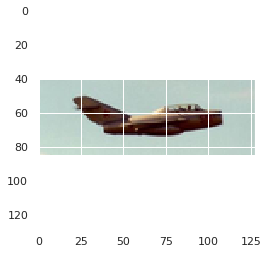

In [318]:
# show image
imgplot = plt.imshow(data[129])
plt.show()

In [0]:
# Transformando las labels de texto a valores numéricos
y = np.unique(labels)
mapping = { key : value for key,value in zip(y,range(len(y)))}
processed_labels = np.array([mapping[i] for i in labels])

In [320]:
print(processed_labels[129])

6


## Preprocesado datos

In [0]:
# A partir del conjunto de datos, hacemos 3 subconjuntos de datos (Train, Validacion y Test)
# Al mismo tiempo creamos un diccionario para saber la cantidad de imagenes que hay en cada categoria del conjunto de datos total
train_rate = 0.8
val_rate = 0.1
number_of_classes = 102
train_data = np.array([])
train_labels = np.array([])
val_data = np.array([])
val_labels = np.array([])
test_data = np.array([])
test_labels = np.array([])
n_elem_category = {}
for i in range(number_of_classes):
    mask = np.where(processed_labels == i)[0] # needed because train_labels has 2 dimensions
    l = len(data[mask[:]])
    n_elem_category.update({y[i]: l})
    tr = round(train_rate*l)
    vr = round((train_rate + val_rate)*l)
    if i == 0:
        # train
        train_data = data[mask[:tr]]
        train_labels = processed_labels[mask[:tr]]
        # validation
        val_data = data[mask[tr:vr]]
        val_labels = processed_labels[mask[tr:vr]]
        # test
        test_data = data[mask[vr:l]]
        test_labels = processed_labels[mask[vr:l]]
    else:
        # train
        train_data = np.concatenate((train_data,data[mask[:tr]]))
        train_labels = np.concatenate((train_labels,processed_labels[mask[:tr]]))
        # validation
        val_data = np.concatenate((val_data,data[mask[tr:vr]]))
        val_labels = np.concatenate((val_labels,processed_labels[mask[tr:vr]]))
        # test
        test_data = np.concatenate((test_data,data[mask[vr:l]]))
        test_labels = np.concatenate((test_labels,processed_labels[mask[vr:l]]))

In [0]:
# Añadimos una dimensión (a los labels)
train_labels = np.expand_dims(train_labels, axis=1)
val_labels = np.expand_dims(val_labels, axis=1)
test_labels = np.expand_dims(test_labels, axis=1)

In [0]:
# One hot encoding (a los labels)
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [324]:
# Shape de los subconjuntos de datos
# Train
print('- Train:')
print('· Data:',train_data.shape)
print('· Labels:',train_labels.shape,'\n')
# Train
print('- Validation:')
print('· Data:',val_data.shape)
print('· Labels:',val_labels.shape,'\n')
# Test
print('- Test:')
print('· Data:',test_data.shape)
print('· Labels:',test_labels.shape,'\n')
# Comprovación 
print('Total datos:',train_labels.shape[0]+val_labels.shape[0]+test_labels.shape[0])

- Train:
· Data: (7315, 128, 128, 3)
· Labels: (7315, 102) 

- Validation:
· Data: (917, 128, 128, 3)
· Labels: (917, 102) 

- Test:
· Data: (913, 128, 128, 3)
· Labels: (913, 102) 

Total datos: 9145


In [325]:
# Cantidad de imagenes por categoría (del conjunto de datos total)
n_elem_category

{'BACKGROUND_Google': 468,
 'Faces': 435,
 'Faces_easy': 435,
 'Leopards': 200,
 'Motorbikes': 798,
 'accordion': 55,
 'airplanes': 800,
 'anchor': 42,
 'ant': 42,
 'barrel': 47,
 'bass': 54,
 'beaver': 46,
 'binocular': 33,
 'bonsai': 128,
 'brain': 98,
 'brontosaurus': 43,
 'buddha': 85,
 'butterfly': 91,
 'camera': 50,
 'cannon': 43,
 'car_side': 123,
 'ceiling_fan': 47,
 'cellphone': 59,
 'chair': 62,
 'chandelier': 107,
 'cougar_body': 47,
 'cougar_face': 69,
 'crab': 73,
 'crayfish': 70,
 'crocodile': 50,
 'crocodile_head': 51,
 'cup': 57,
 'dalmatian': 67,
 'dollar_bill': 52,
 'dolphin': 65,
 'dragonfly': 68,
 'electric_guitar': 75,
 'elephant': 64,
 'emu': 53,
 'euphonium': 64,
 'ewer': 85,
 'ferry': 67,
 'flamingo': 67,
 'flamingo_head': 45,
 'garfield': 34,
 'gerenuk': 34,
 'gramophone': 51,
 'grand_piano': 99,
 'hawksbill': 100,
 'headphone': 42,
 'hedgehog': 54,
 'helicopter': 88,
 'ibis': 80,
 'inline_skate': 31,
 'joshua_tree': 64,
 'kangaroo': 86,
 'ketch': 114,
 'lamp':

## Funciones

In [0]:
# Plot de las gráficas de Accuracy y Loss
def plot_acc_loss(history):
  epochs = np.arange(1,len(history.history['acc'])+1)
  names = ['accuracy', 'loss']
  label_names_train = ['training acc', 'training loss']
  label_names_val = ['validation acc', 'validation loss']
  history_names_train = ['acc', 'loss']
  history_names_val = ['val_acc', 'val_loss']
  plt.figure(figsize=(15, 5))
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title('Model ({})'.format(names[i]))
    plt.xlabel('epoch')
    plt.ylabel(names[i])
    plt.plot(epochs,history.history[history_names_train[i]],'r',label = label_names_train[i] )
    plt.plot(epochs,history.history[history_names_val[i]],'b',label = label_names_val[i])
    plt.legend(loc='best')    
  plt.show()

In [0]:
# Evaluación del modelo (con el conjunto de datos test)
def eval_model(model_trained):
  score = model_trained.evaluate(test_data, test_labels, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

In [0]:
# Métricas por clase
def class_met(model_trained):
  from sklearn.metrics import classification_report
  predicted_classes  = model_trained.predict_classes(test_data)  
  classif_report = classification_report(np.argmax(test_labels, axis=1), predicted_classes, target_names=y)  
  print(classif_report)

In [0]:
# Matriz de confusión
def mat_confusion(model_trained):
  # Creamos la matriz de confusión
  predicted_classes  = model_trained.predict_classes(test_data)
  matrix_confusion = confusion_matrix(np.argmax(test_labels, axis=1), predicted_classes)

  # Visualizamos la matriz de confusión
  matrix_confusion_df = pd.DataFrame(matrix_confusion, range(102), range(102))  
  plt.figure(figsize = (22,22))  
  sn.set(font_scale=1) #for label size  
  sn.heatmap(matrix_confusion_df, annot=True, annot_kws={"size": 8}) # font size  
  plt.show()  

In [0]:
# Predecir la categoria de una imagen
def pred_img(nimg, model): 
  # Imagen
  x = test_data[nimg]
  x = np.expand_dims(x, axis=0)
  print('Imagen del Test Nº', nimg)
  # Mostrar imagen
  img = plt.imshow(test_data[nimg])
  plt.show()
  # Categoria Real
  cat_real = y[np.argmax(test_labels[nimg])]
  # Categoria Predicha
  prediction = model.predict(x)
  output_index = np.argmax(prediction[0])
  res = prediction[0][output_index]*100
  print('· Categoría Real:',cat_real)
  print('· Categoría Predicha:', y[output_index],'({0:.2f} %)'.format(res))
  print('Nº imagenes (Categoría Real):',n_elem_category[cat_real])
  print('----------------------------------------------')

In [0]:
# Comprovación (par saber si una variable tiene len)
def check_len(n):
  try:
    len(n)
    return True
  except TypeError:
    return False

In [0]:
# Predecir la categoria de n imagenes random (dentro del conjunto de test)
def pred_n_img(input, model):
  if check_len(input):
    l = input
    n = len(input)
  else:
    l = []
    n = input
    for i in range(input):
      l.append(randrange (0,test_data.shape[0]+1,1))
  for i in range(n):
    pred_img(l[i], model)

In [0]:
# Plot de una imagen
def plt_img(x):
  plt.figure(figsize = (18,18))
  plt.axis('off')
  plt.imshow(x)

In [0]:
# Predecir la categoria de una imagen + visualizar capa convolucional
def pred_img_2(nimg, model): 
  # Imagen
  x = test_data[nimg]
  x = np.expand_dims(x, axis=0)
  print('Imagen del Test Nº', nimg)
  # Categoria Real
  cat_real = y[np.argmax(test_labels[nimg])]
  # Categoria Predicha
  prediction = model.predict(x)
  output_index = np.argmax(prediction[0])
  res = prediction[0][output_index]*100
  # Visualización de lo que esta viendo la ultima capa convolucional
  output_index = np.argmax(prediction[0])
  output = model.output[:,output_index]
  last_conv_layer = model.get_layer('layer_15')
  grads = K.gradients(output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0,1,2))
  iterate = K.function( [model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  # multiplicar cada canal en el feature map por como de importante el canal es con respecto a la clase
  for i in range(64):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  # visualizar
  heatmap = np.maximum(heatmap,0)
  heatmap /= np.max(heatmap)
  fig,axes = plt.subplots(1,2)
  axes[0].matshow(heatmap)
  axes[1].imshow(test_data[nimg])
  plt.show()
  print('· Categoría Real:',cat_real)
  print('· Categoría Predicha:', y[output_index],'({0:.2f} %)'.format(res))
  print('Nº imagenes (Categoría Real):',n_elem_category[cat_real])
  print('----------------------------------------------')

In [0]:
# Predecir la categoria de n imagenes random (dentro del conjunto de test) + visualizar capa convolucional
def pred_n_img_2(input, model):
  if check_len(input):
    l = input
    n = len(input)
  else:
    l = []
    n = input
    for i in range(input):
      l.append(randrange (0,test_data.shape[0]+1,1))
  for i in range(n):
    pred_img_2(l[i], model)

## Estrategia 1: Red pre-entrenada

### Arquitectura VGG19


In [336]:
# Cargamos el modelo base
base_model_vgg19 = VGG19(weights='imagenet',
                 include_top=False, # incluir la parte densa (fully connected)
                 input_shape=(128,128,3))
base_model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [337]:
# Conectamos el modelo base a una nueva parte densa
base_model_vgg19.trainable = False # evitar que los pesos se modifiquen en la parte convolucional
model_vgg19 = models.Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dense(256, activation='relu'))
model_vgg19.add(layers.Dense(number_of_classes, activation='softmax'))

model_vgg19.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_32 (Dense)             (None, 102)               26214     
Total params: 22,148,006
Trainable params: 2,123,622
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
# Compilación del modelo
model_vgg19.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
# Entrenamiento del modelo
#history_vgg19 = model_vgg19.fit(train_data,train_labels,epochs=30,batch_size=512,validation_data=(val_data,val_labels))

In [0]:
# Visualizamos las gráficas de Accuracy y Loss
#plot_acc_loss(history_vgg19)

In [0]:
# Guardamos el modelo
#model_vgg19.save(BASE_FOLDER + '/trained_models/model_vgg19_trained.h5')

In [342]:
# Cargamos el modelo (entrenado)
model_vgg19_trained = load_model(BASE_FOLDER + '/trained_models/model_vgg19_trained.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


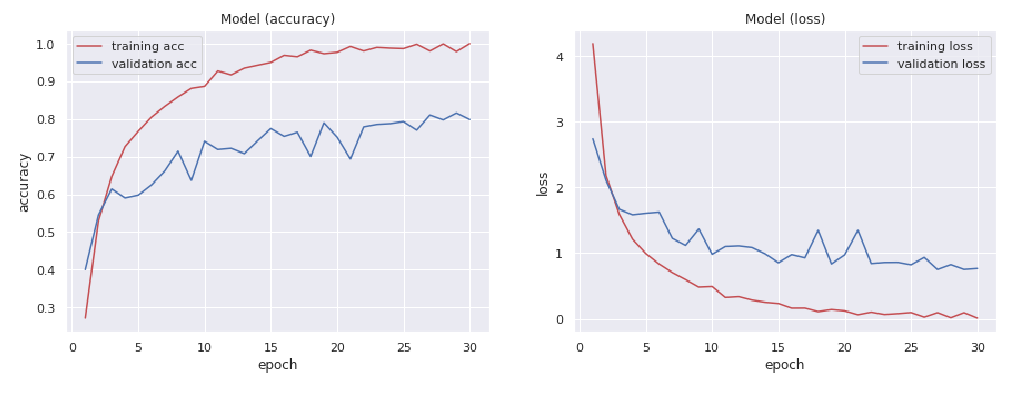

In [343]:
# Gráfica de accuracy y lose
model_vgg19_trained_plot = image.load_img(BASE_FOLDER + '/trained_models/vgg19.PNG')
plt_img(model_vgg19_trained_plot)

In [344]:
# Evaluamos el modelo
eval_model(model_vgg19_trained)

Test loss: 0.7476158528099084
Test accuracy: 0.8214676893292747


In [345]:
# Visualizamos las métricas por clase
class_met(model_vgg19_trained)

                   precision    recall  f1-score   support

BACKGROUND_Google       0.46      0.66      0.54        47
            Faces       1.00      1.00      1.00        43
       Faces_easy       0.98      1.00      0.99        43
         Leopards       0.91      1.00      0.95        20
       Motorbikes       1.00      1.00      1.00        80
        accordion       1.00      0.80      0.89         5
        airplanes       0.95      1.00      0.98        80
           anchor       0.67      0.50      0.57         4
              ant       0.67      1.00      0.80         4
           barrel       0.57      0.80      0.67         5
             bass       0.33      0.20      0.25         5
           beaver       0.00      0.00      0.00         5
        binocular       1.00      0.33      0.50         3
           bonsai       1.00      1.00      1.00        13
            brain       0.90      0.90      0.90        10
     brontosaurus       0.75      0.75      0.75       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


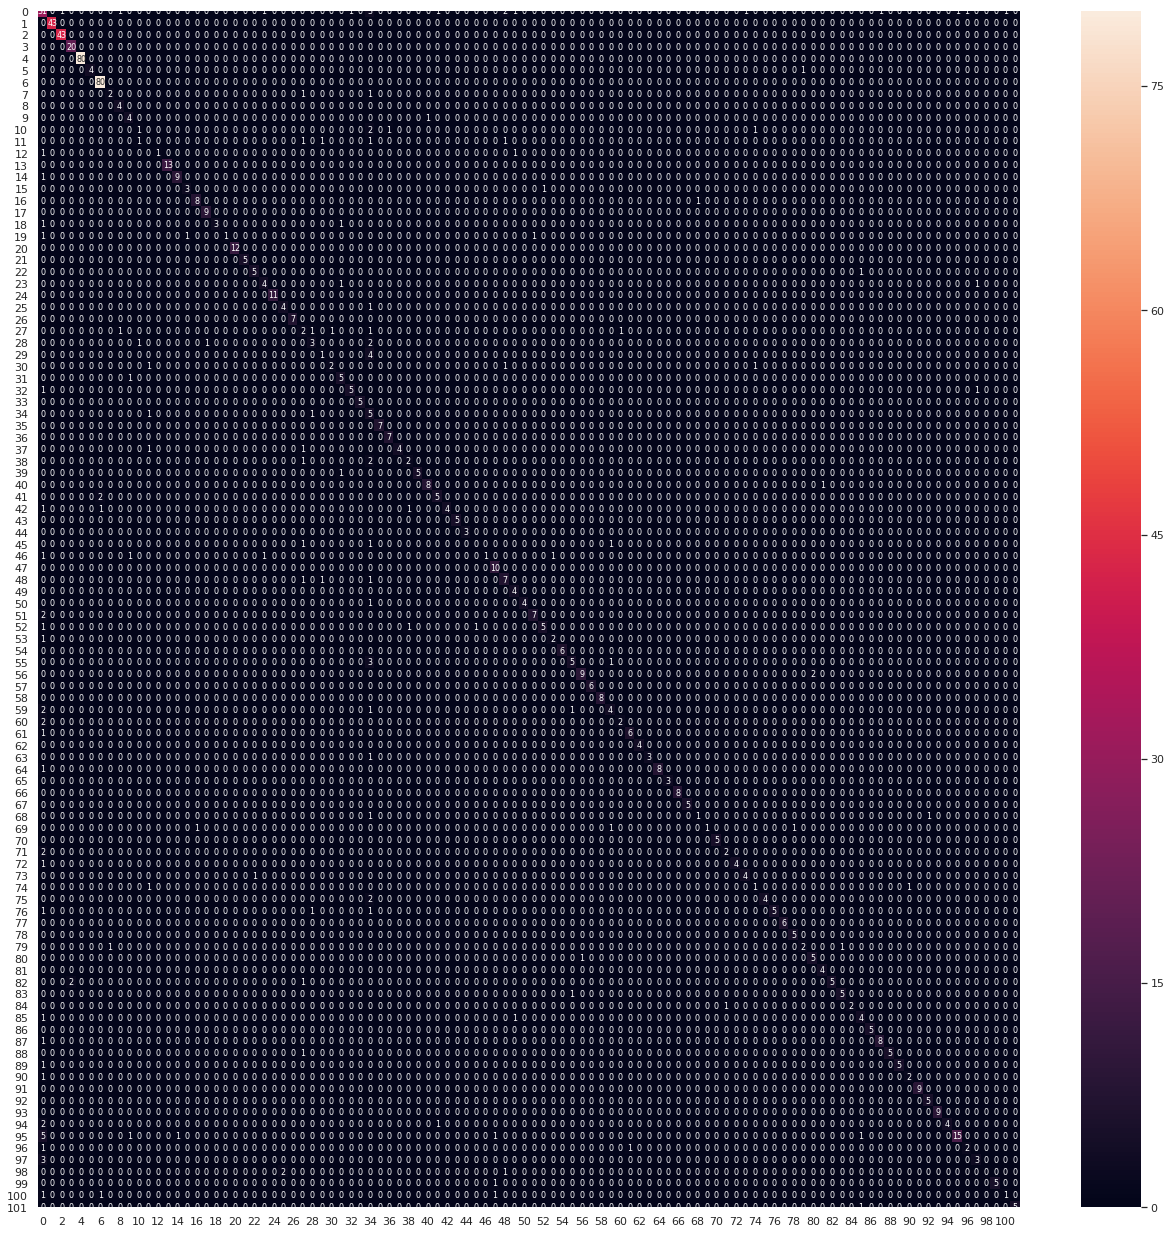

In [346]:
# Matriz de confusión
mat_confusion(model_vgg19_trained)

### Arquitectura MobileNetV2


In [347]:
# Cargamos el modelo base
base_model_MobileNetV2 = MobileNetV2(weights='imagenet',
                 include_top=False, # incluir la parte densa (fully connected)
                 input_shape=(128,128,3))
base_model_MobileNetV2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [348]:
# Conectamos el modelo base a una nueva parte densa
base_model_MobileNetV2.trainable = False # evitar que los pesos se modifiquen en la parte convolucional
model_MobileNetV2 = models.Sequential()
model_MobileNetV2.add(base_model_MobileNetV2)
model_MobileNetV2.add(layers.Flatten())
model_MobileNetV2.add(layers.Dense(256, activation='relu'))
model_MobileNetV2.add(layers.Dense(number_of_classes, activation='softmax'))

model_MobileNetV2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_17 (Flatten)         (None, 20480)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               5243136   
_________________________________________________________________
dense_34 (Dense)             (None, 102)               26214     
Total params: 7,527,334
Trainable params: 5,269,350
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# Compilación del modelo
model_MobileNetV2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
# Entrenamiento del modelo
#history_model_MobileNetV2 = model_MobileNetV2.fit(train_data,train_labels,epochs=30,batch_size=512,validation_data=(val_data,val_labels))

In [0]:
# Visualizamos las gráficas de Accuracy y Loss
#plot_acc_loss(history_model_MobileNetV2)

In [0]:
# Guardamos el modelo
#model_MobileNetV2.save(BASE_FOLDER + '/trained_models/model_MobileNetV2_trained.h5')

In [353]:
# Cargamos el modelo (entrenado)
model_MobileNetV2_trained = load_model(BASE_FOLDER + '/trained_models/model_MobileNetV2_trained.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


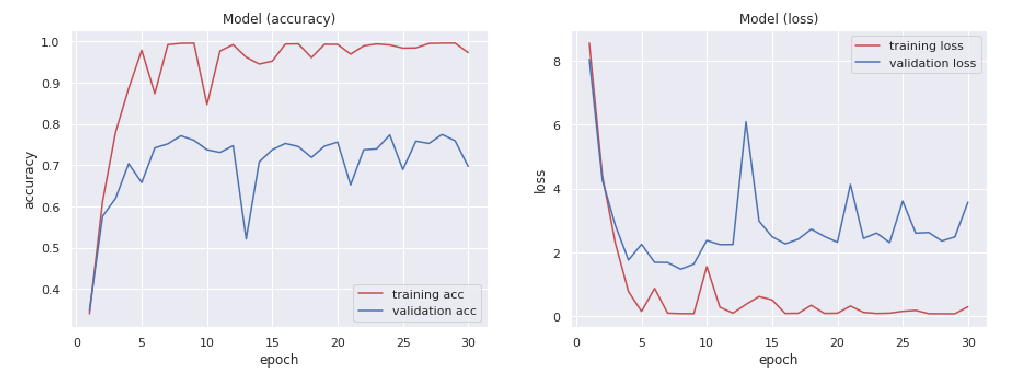

In [354]:
# Gráfica de accuracy y lose
model_MobileNetV2_trained_plot = image.load_img(BASE_FOLDER + '/trained_models/mobilenetv2.PNG')
plt_img(model_MobileNetV2_trained_plot)

In [355]:
# Evaluamos el modelo
eval_model(model_MobileNetV2_trained)

Test loss: 3.253814677751969
Test accuracy: 0.7053669227566672


In [356]:
# Visualizamos las métricas por clase
class_met(model_MobileNetV2_trained)

                   precision    recall  f1-score   support

BACKGROUND_Google       0.81      0.28      0.41        47
            Faces       0.81      1.00      0.90        43
       Faces_easy       1.00      0.77      0.87        43
         Leopards       1.00      0.20      0.33        20
       Motorbikes       0.94      0.99      0.96        80
        accordion       1.00      0.60      0.75         5
        airplanes       0.73      0.97      0.83        80
           anchor       0.00      0.00      0.00         4
              ant       0.50      0.25      0.33         4
           barrel       0.71      1.00      0.83         5
             bass       1.00      0.60      0.75         5
           beaver       0.00      0.00      0.00         5
        binocular       0.00      0.00      0.00         3
           bonsai       1.00      0.69      0.82        13
            brain       0.56      1.00      0.71        10
     brontosaurus       0.30      0.75      0.43       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


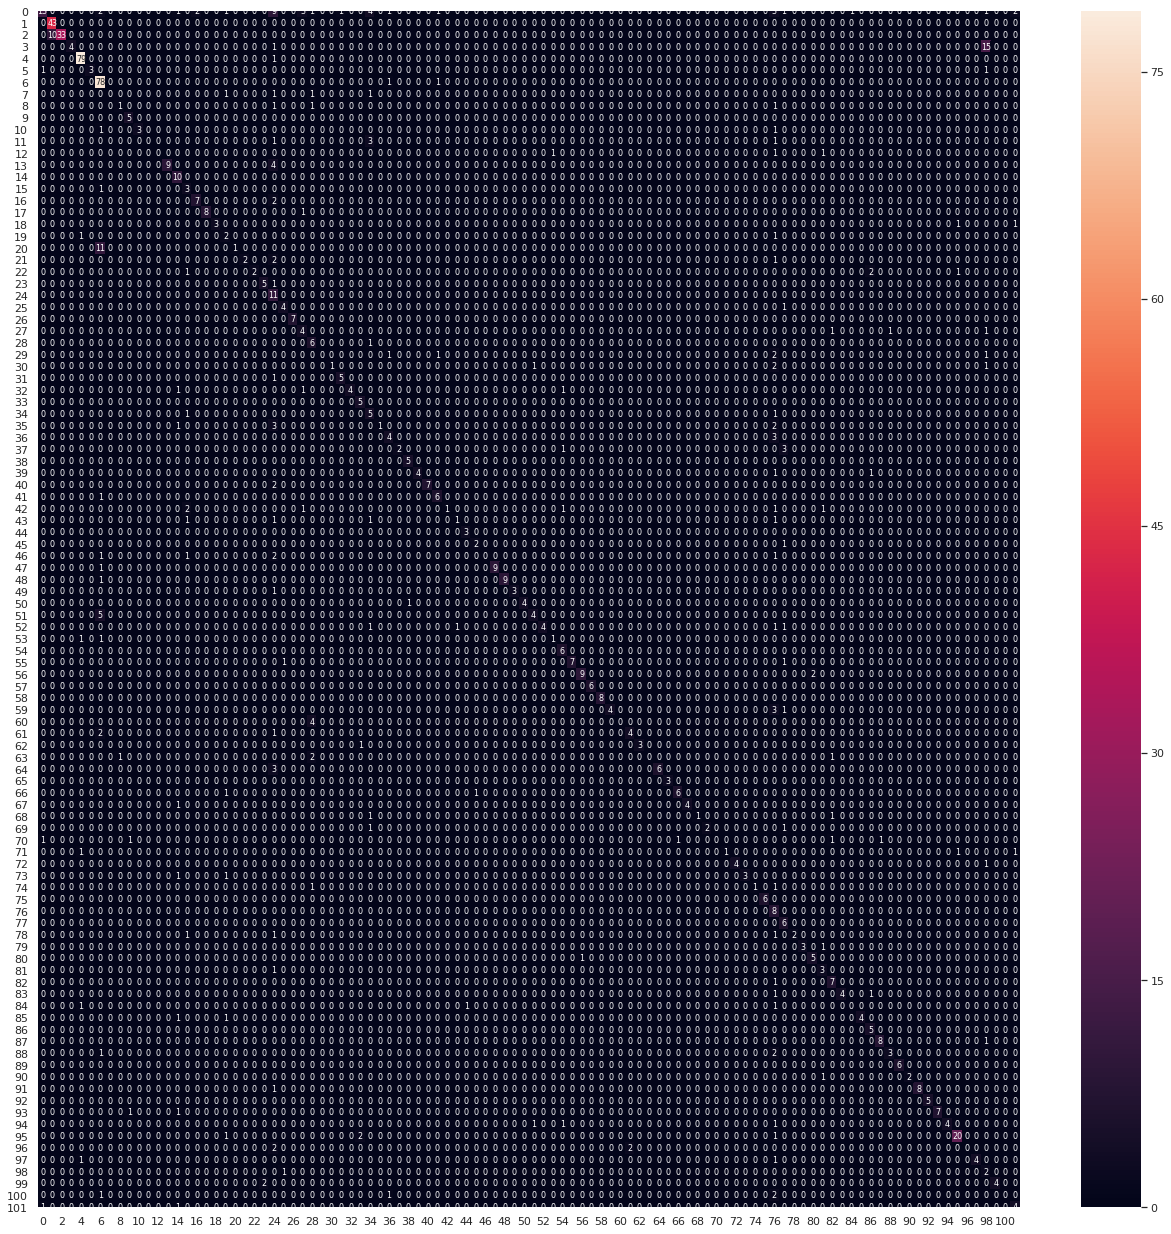

In [0]:
# Matriz de confusión
mat_confusion(model_MobileNetV2_trained)

### Comparativa de resultados

·VGG19
Test loss: 0.7476158528099084
Test accuracy: 0.8214676893292747


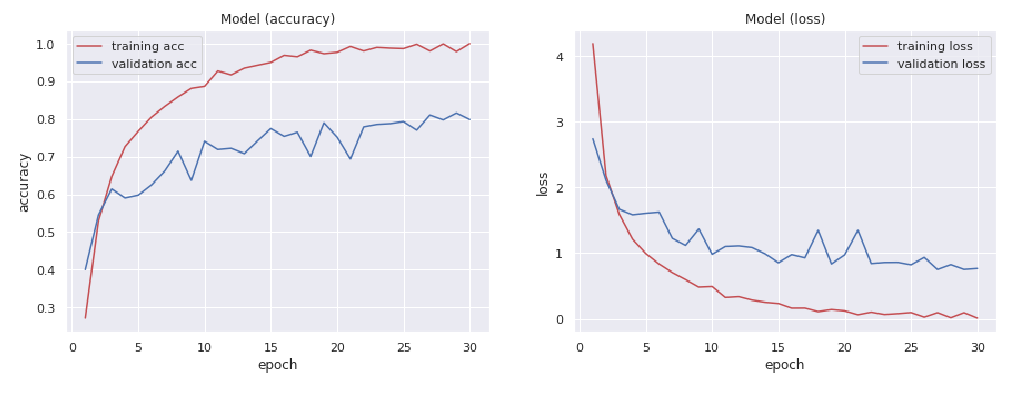

In [357]:
# VGG19
print('·VGG19')
eval_model(model_vgg19_trained)
plt_img(model_vgg19_trained_plot)


·MobileNetV2
Test loss: 3.253814677751969
Test accuracy: 0.7053669227566672


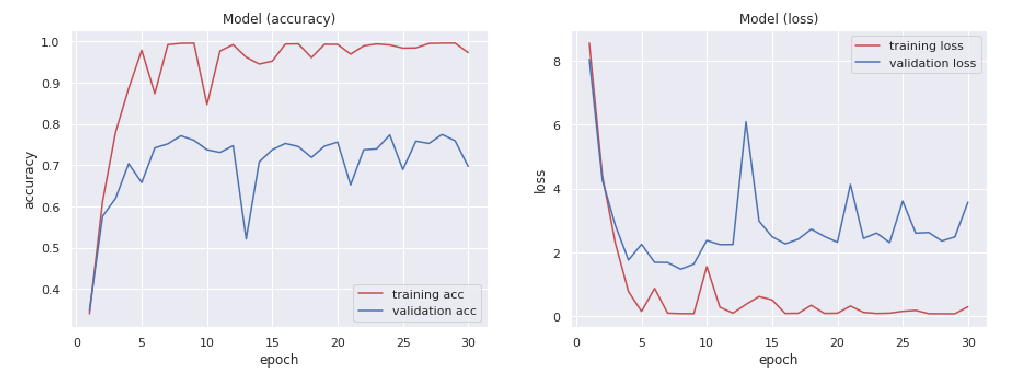

In [358]:
# MobileNetV2
print('\n·MobileNetV2')
eval_model(model_MobileNetV2_trained)
plt_img(model_MobileNetV2_trained_plot)

El modelo vgg19 ha obtenido un resultado muy superior al de mobilenetv2, debido a que tiene un loss mucho más bajo. En las gráficas de vgg19 se puede observar que las línias de validación siguen la misma tendencia que las línias de entrenamiento. En cambio en las de mobilenetv2 no lo hace y tine bastantes altibajos. También se puede apreciar que el modelo de vgg19 tiene un poco de overfitting debido a que el loss de validación es superior al de entrenamiento. En el caso de mobilenetv2 es el loss validación es muy superior al de entrenamiento, por lo tanto tiene bastante overfitting.

La elección de los parámetros de entrenamiento se basan en las diferentes pruebas que se han realizado, con la conclusion que es mejor un tamaño de batch grande, en el caso de transfer learning para disminuir el loss de validación. Por el hecho de que no se ajustan con tanta frecuencia los pesos y de esta manera no se modifica drásticamente la estructura base de la arquitectura (refiriendose a los pesos).

## Estrategia 2: Entrenar desde cero

### Construcción y optimización del modelo

Se partirá de un modelo base que he nombrado alpha_0 (basado en la arquitectura VGG16), se irán cargando las variaciones del modelo para ver la estructura de cada uno, se mostraran las gráficas de accuracy y loss de entrenamiento y validación, y se evaluará el modelo en un conjunto de datos test.

#### Model alpha

In [0]:
# Construcción de una red CNN (Convolutional Neural Network)
model_alpha = Sequential()
model_alpha.add(Conv2D(32, (3, 3), input_shape=(128,128,3)))
model_alpha.add(BatchNormalization())
model_alpha.add(LeakyReLU(alpha=0.1))

model_alpha.add(Conv2D(64, (3, 3)))
model_alpha.add(BatchNormalization())
model_alpha.add(LeakyReLU(alpha=0.1))
model_alpha.add(MaxPooling2D((2, 2)))
model_alpha.add(Dropout(0.5))

model_alpha.add(Conv2D(128, (3, 3)))
model_alpha.add(BatchNormalization())
model_alpha.add(LeakyReLU(alpha=0.1))
model_alpha.add(MaxPooling2D((4, 4)))
model_alpha.add(Dropout(0.5))

model_alpha.add(Conv2D(256, (3, 3)))
model_alpha.add(BatchNormalization())
model_alpha.add(LeakyReLU(alpha=0.1))
model_alpha.add(MaxPooling2D((4, 4)))
model_alpha.add(Dropout(0.5))

model_alpha.add(Flatten())

model_alpha.add(Dense(512))
model_alpha.add(LeakyReLU(alpha=0.1))
model_alpha.add(Dropout(0.5))
model_alpha.add(Dense(number_of_classes, activation='softmax'))

model_alpha.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)       

In [0]:
# Compilación del modelo
model_alpha.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
# Entrenamiento del modelo
#history = model_alpha.fit(train_data,train_labels,epochs=50,batch_size=64,validation_data=(val_data,val_labels))

In [0]:
# Visualizamos las gráficas de Accuracy y Loss
#plot_acc_loss(history)

In [0]:
# Guardamos el modelo
#model_alpha.save(BASE_FOLDER + 'model_alpha.h5')

#### Model alpha_0

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_0 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_0.h5')

model_alpha_0.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 256)       295168    
____________

Los filtros de MaxPooling2D son de (2,2) en todas las capas convolucionales.

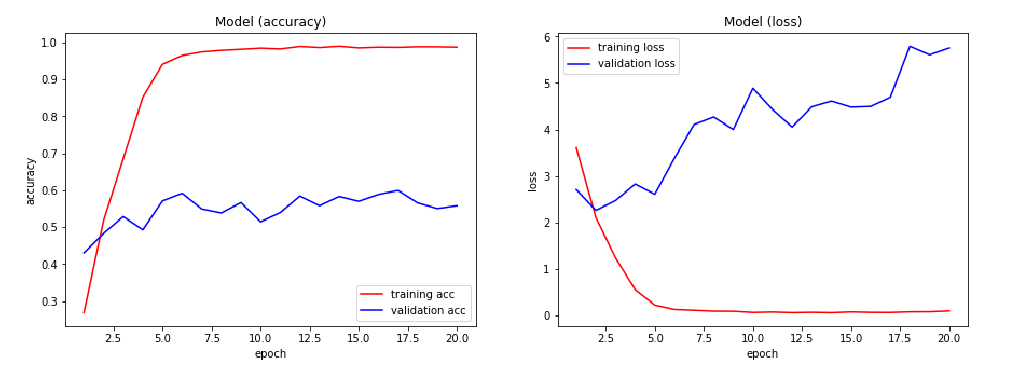

In [0]:
# Gráfica de accuracy y lose
model_alpha_0_plot = image.load_img(BASE_FOLDER + '/model_alpha/0.PNG')
plt_img(model_alpha_0_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_0)

Test loss: 5.290447115150552
Test accuracy: 0.602409638586859


El modelo no esta aprendiendo, solo esta memorizando los datos de entrenamiento (overfitting). Y tenemos que el loss se va incrementando, por lo tanto esta desaprendiendo el modelo. Tenemos un accuracy de 0,6 pero con un loss muy elevado de 5,29.

#### Model alpha_1

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_1 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_1.h5')

model_alpha_1.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 3, 256)       

Los filtros de MaxPooling2D son de (4,4) en las capas convolucionales de 256 y 128. Y de (2,2) en la capa 64. De esta manera reducimos considerablemente el número de parámetros.

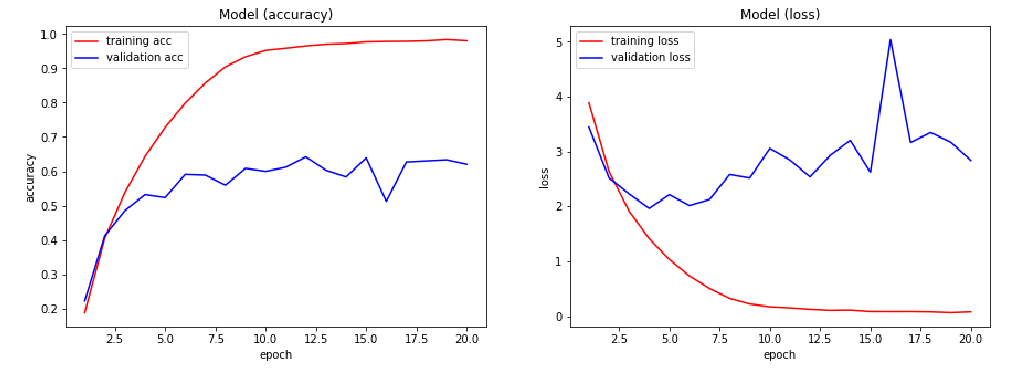

In [0]:
# Gráfica de accuracy y lose
model_alpha_1_plot = image.load_img(BASE_FOLDER + '/model_alpha/1.PNG')
plt_img(model_alpha_1_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_1)

Test loss: 2.7163061831842175
Test accuracy: 0.6495071198436282


Hemos mejorado el accuracy y reducido el loss (nos quedamos con esta configuración de MaxPooling2D), pero seguimos teniendo que el loss se va incrementando durante el transcurso de las epocas. Respecto al accuracy del entrenamiento observamos que continuamos con el overfitting. 

#### Model alpha_2

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_2 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_2.h5')

model_alpha_2.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 15, 128)       0         
__

Añadimos dropout (inhabilitar neuronas durante el entrenamiento) con el valor de 0,5. Por lo tanto significa que se apagan la mitad de las neuronas, en las capas dónde se ha añadido droput. De esta manera se reduce el overfitting.

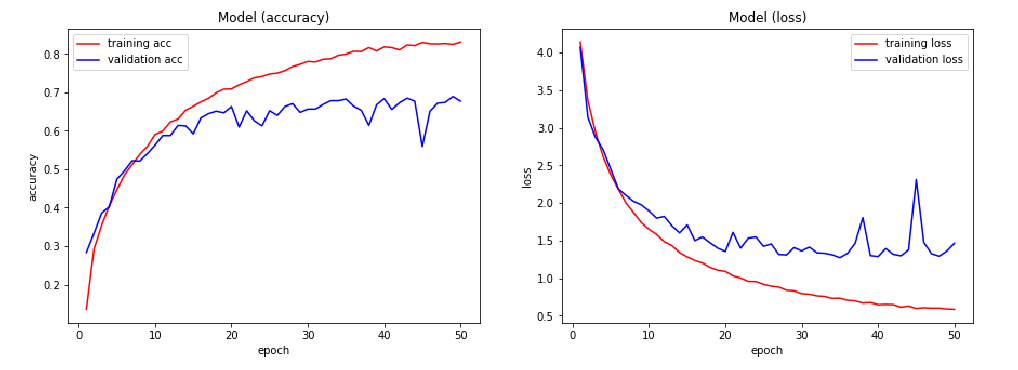

In [0]:
# Gráfica de accuracy y lose
model_alpha_2_plot = image.load_img(BASE_FOLDER + '/model_alpha/2.PNG')
plt_img(model_alpha_2_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_2)

Test loss: 1.367722646851664
Test accuracy: 0.7097480836337655


Mejoramos el accuracy hasta el 0,7 y el loss lo reducimos de manera considerable hasta 1,36. Podemos observar que ahora las gráficas de validación de accuracy y loss siguen la línea de las de entrenamiento.

#### Model alpha_2_1

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_2_1 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_2_1.h5')

model_alpha_2_1.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 57, 57, 128)     

Ahora variamos el valor del dropout de la siguiente manera:
- 1ro dropout: 0,1
- 2do dropout: 0,2
- 3ro dropout: 0,1
- 4to dropout: 0,4

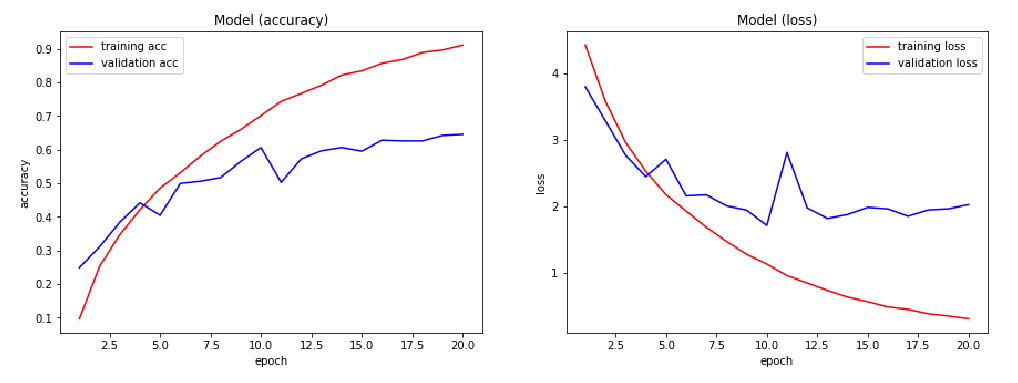

In [0]:
# Gráfica de accuracy y lose
model_alpha_2_1_plot = image.load_img(BASE_FOLDER + '/model_alpha/2_1.PNG')
plt_img(model_alpha_2_1_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_2_1)

Test loss: 1.9884106149170946
Test accuracy: 0.6692223443781298


Respecto a los valores de dropout del modelo alpha_2, estos son peores. La gráfica de accuracy validación al principio si sigue la línia de entrenamiento, pero a medida que van transcurriendo las épocas deja de hacerlo. Y en la gráfica de loss, el loss validación al final tiende a incrementar.
Por lo tanto nos quedaremos con la configuración del dropout con valor de 0,5.

#### Model alpha_3

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_3 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_3.h5')

model_alpha_3.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 57, 57, 128)     

Duplicamos las capas convolucionales.

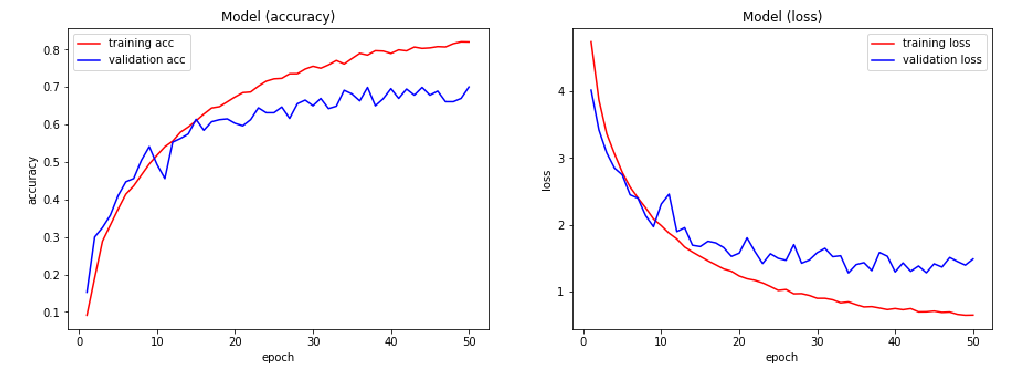

In [0]:
# Gráfica de accuracy y lose
model_alpha_3_plot = image.load_img(BASE_FOLDER + '/model_alpha/3.PNG')
plt_img(model_alpha_3_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_3)

Test loss: 1.404559059445596
Test accuracy: 0.7086527933165643


Resultados bastante similares al modelo alpha_2, pero con el test loss ligeramente más elevado.

#### Model alpha_3_1

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_3_1 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_3_1.h5')

model_alpha_3_1.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 58, 58, 128)     

Triplicamos las capas convolucionales.

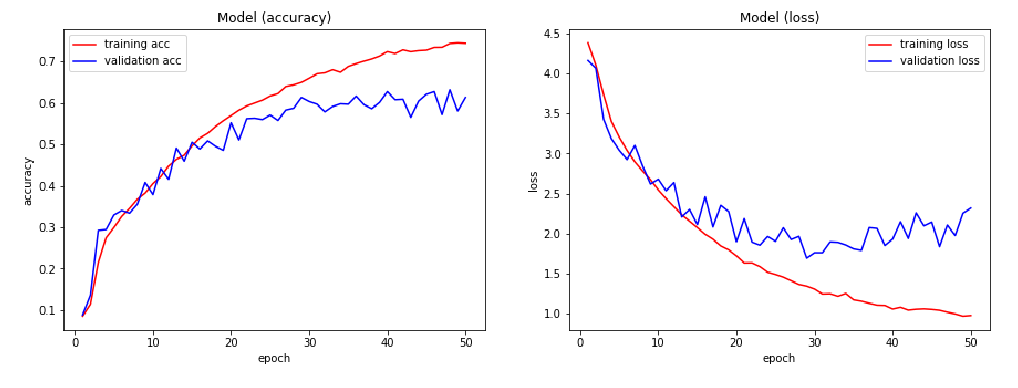

In [0]:
# Gráfica de accuracy y lose
model_alpha_3_1_plot = image.load_img(BASE_FOLDER + '/model_alpha/3_1.PNG')
plt_img(model_alpha_3_1_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_3_1)

Test loss: 2.101103679592323
Test accuracy: 0.6265060244880919


En este caso los resultados son peores. El loss validación al final termina incrementandose tal y como se puede observar en la gráfica.

#### Model alpha_4

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_4 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_4.h5')

model_alpha_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)      

El canvio en este caso es la función de activación, en vez de ReLU se utilizará la LeakyReLU que és más avanzada.

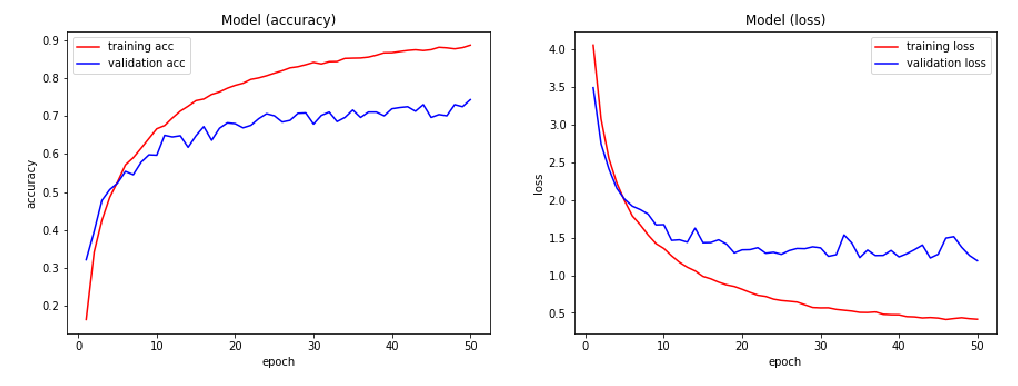

In [0]:
# Gráfica de accuracy y lose
model_alpha_4_plot = image.load_img(BASE_FOLDER + '/model_alpha/4.PNG')
plt_img(model_alpha_4_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_4)

Test loss: 1.1965915409628076
Test accuracy: 0.7710843373820397


Los resultados son bastante mejores, se obtiene un accuracy del 0,77 y tambien se ha reducido el loss a 1,19 (el modelo a partir de ahora la función de activación será la LeakyReLU). En las gráficas se puede observar que el accuracy validación al final deja de seguir la línia de entrenamiento y en el loss sucede lo mismo. Eso significa que el modelo tiene overfitting.

#### Model alpha_5

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_5 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_5.h5')

model_alpha_5.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 62, 62, 64)      

Se añade Batch_Normalization para que los valores esten ajustados y escalados (normalizados) para la activación de la capa.

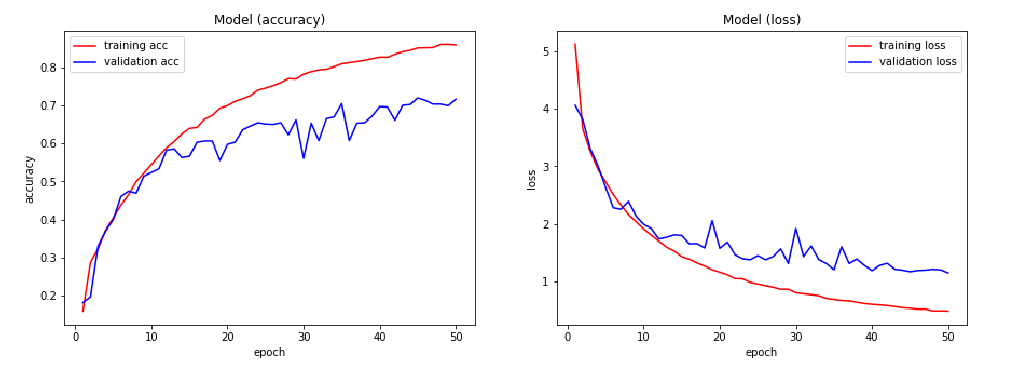

In [0]:
# Gráfica de accuracy y lose
model_alpha_5_plot = image.load_img(BASE_FOLDER + '/model_alpha/5.PNG')
plt_img(model_alpha_5_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_5)

Test loss: 1.0638203356227565
Test accuracy: 0.7502738229546855


Son los mejores resultados que se han obtenido hasta ahora, con un test loss del 1,06 y un accuracy del 0,75 (se añade a la configuración del modelo el Batch_Normalization). En las gráficas se puede observar como las líneas de validación siguen a las de entrenamiento.

#### Model alpha_6

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_6 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_6.h5')

model_alpha_6.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 62, 62, 64)      

Otra técnica para prevenir el overfitting es la regularización de los pesos y el bias. En este caso se utliza la regularización L2 en la 1era capa convolucional. Con el kernel y bias regularizer igual a 0,01.

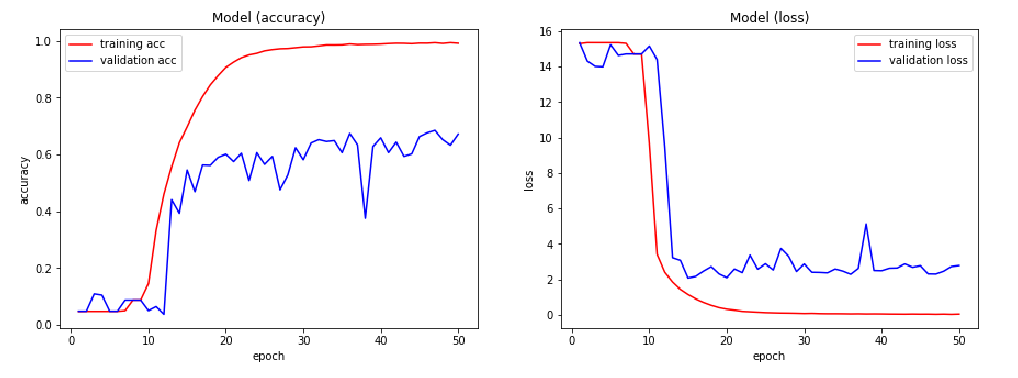

In [0]:
# Gráfica de accuracy y lose
model_alpha_6_plot = image.load_img(BASE_FOLDER + '/model_alpha/6.PNG')
plt_img(model_alpha_6_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_6)

Test loss: 2.768287406652872
Test accuracy: 0.6900328591645483


Los resultados son peores debido a que se obtiene un test loss del 2,76. Y en las gráficas se pude observar que las líneas de validación no siguen a las de entrenamiento, se mantienen paralelas sin que augmente el accuracy ni reduzca el loss.

#### Model alpha (optimizador Adam)

El mejor modelo obtenido es el model_alpha_5. En todos los modelos el optimizador ha sido el rmsprop. En este caso probaremos el model_alpha_5 con el optimizador Adam.

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_opt_adam = load_model(BASE_FOLDER + '/model_alpha/model_alpha_opt_adam.h5')

model_alpha_opt_adam.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 64)       

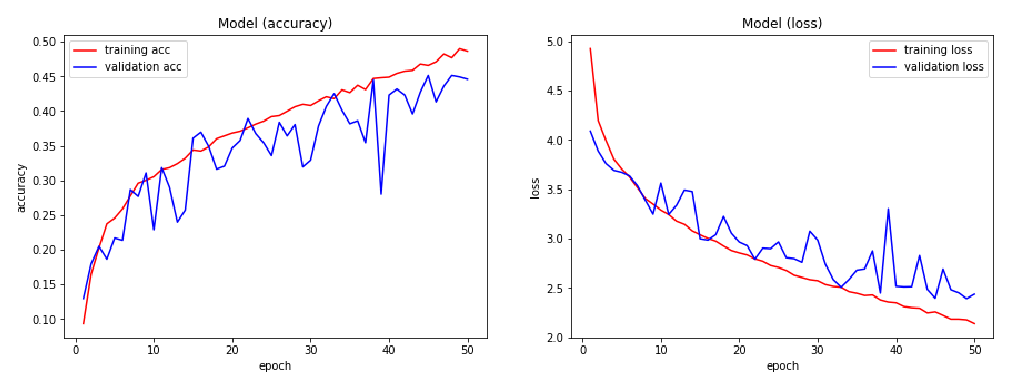

In [0]:
# Gráfica de accuracy y lose
model_alpha_opt_adam_plot = image.load_img(BASE_FOLDER + '/model_alpha/opt_adam.PNG')
plt_img(model_alpha_opt_adam_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_opt_adam)

Test loss: 2.3703792849871834
Test accuracy: 0.44906900344908174


A pesar que de cierta manera (con subidas y bajadas) la línea de validación sigue a la de entrenamiento tanto en la gráfica de accuracy como la de loss, los resultados de la evaluación son mucho peroes que con el optimizador rmsprop.

#### Model alpha (batch 128)

El mejor modelo obtenido es el model_alpha_5. En todos los modelos para el entranmiento se ha utilizado un batch de 64. En este caso probaremos con un batch de 128.

In [0]:
# Cargamos el modelo (entrenado)
model_alpha_batch_128 = load_model(BASE_FOLDER + '/model_alpha/model_alpha_batch_128.h5')

model_alpha_batch_128.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 124, 124, 64)      256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)       

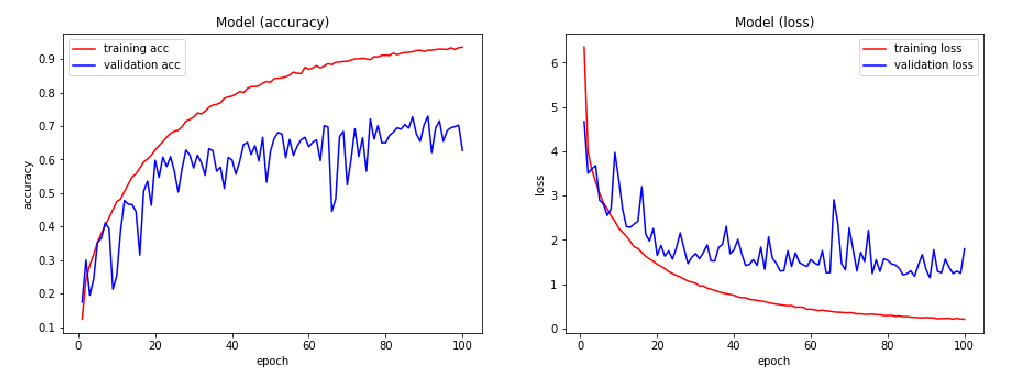

In [0]:
# Gráfica de accuracy y lose
model_alpha_batch_128_plot = image.load_img(BASE_FOLDER + '/model_alpha/batch_128.PNG')
plt_img(model_alpha_batch_128_plot)

In [0]:
# Evaluación del modelo
eval_model(model_alpha_batch_128)

Test loss: 1.6852948896164586
Test accuracy: 0.6407447977630097


El resultado es peor y las líneas de validación de accuracy y loss tienen muchos alitbajos.

### Comparativa de resultados

In [0]:
# Comparativa de los resultados de las evaluaciones de las diferentes configuraciones del modelo alpha
print('·Model_alpha_0')
eval_model(model_alpha_0)
print('\n·Model_alpha_1')
eval_model(model_alpha_1)
print('\n·Model_alpha_2')
eval_model(model_alpha_2)
print('\n·Model_alpha_2_1')
eval_model(model_alpha_2_1)
print('\n·Model_alpha_3')
eval_model(model_alpha_3)
print('\n·Model_alpha_3_1')
eval_model(model_alpha_3_1)
print('\n·Model_alpha_4')
eval_model(model_alpha_4)
print('\n·Model_alpha_5')
eval_model(model_alpha_5)
print('\n·Model_alpha_6')
eval_model(model_alpha_6)
print('\n·Model_alpha_opt_adam')
eval_model(model_alpha_opt_adam)
print('\n·Model_alpha_batch_128')
eval_model(model_alpha_batch_128)

·Model_alpha_0
Test loss: 5.290447115150552
Test accuracy: 0.602409638586859

·Model_alpha_1
Test loss: 2.7163061831842175
Test accuracy: 0.6495071198436282

·Model_alpha_2
Test loss: 1.367722646851664
Test accuracy: 0.7097480836337655

·Model_alpha_2_1
Test loss: 1.9884106149170946
Test accuracy: 0.6692223443781298

·Model_alpha_3
Test loss: 1.404559059445596
Test accuracy: 0.7086527933165643

·Model_alpha_3_1
Test loss: 2.101103679592323
Test accuracy: 0.6265060244880919

·Model_alpha_4
Test loss: 1.1965915409628076
Test accuracy: 0.7710843373820397

·Model_alpha_5
Test loss: 1.0638203356227565
Test accuracy: 0.7502738229546855

·Model_alpha_6
Test loss: 2.768287406652872
Test accuracy: 0.6900328591645483

·Model_alpha_opt_adam
Test loss: 2.3703792849871834
Test accuracy: 0.44906900344908174

·Model_alpha_batch_128
Test loss: 1.6852948896164586
Test accuracy: 0.6407447977630097


Como se puede observar la mejor configuración es la del Model_alpha_5.

### Modelo Final (alpha_5)

In [0]:
# Visualizamos las métricas por clase
class_met(model_alpha_5)

                   precision    recall  f1-score   support

BACKGROUND_Google       0.60      0.45      0.51        47
            Faces       0.96      1.00      0.98        43
       Faces_easy       0.98      1.00      0.99        43
         Leopards       1.00      1.00      1.00        20
       Motorbikes       0.99      1.00      0.99        80
        accordion       0.83      1.00      0.91         5
        airplanes       0.90      1.00      0.95        80
           anchor       0.25      0.25      0.25         4
              ant       0.67      0.50      0.57         4
           barrel       0.22      0.40      0.29         5
             bass       1.00      0.60      0.75         5
           beaver       0.67      0.40      0.50         5
        binocular       0.00      0.00      0.00         3
           bonsai       0.80      0.92      0.86        13
            brain       0.43      0.30      0.35        10
     brontosaurus       1.00      0.50      0.67       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


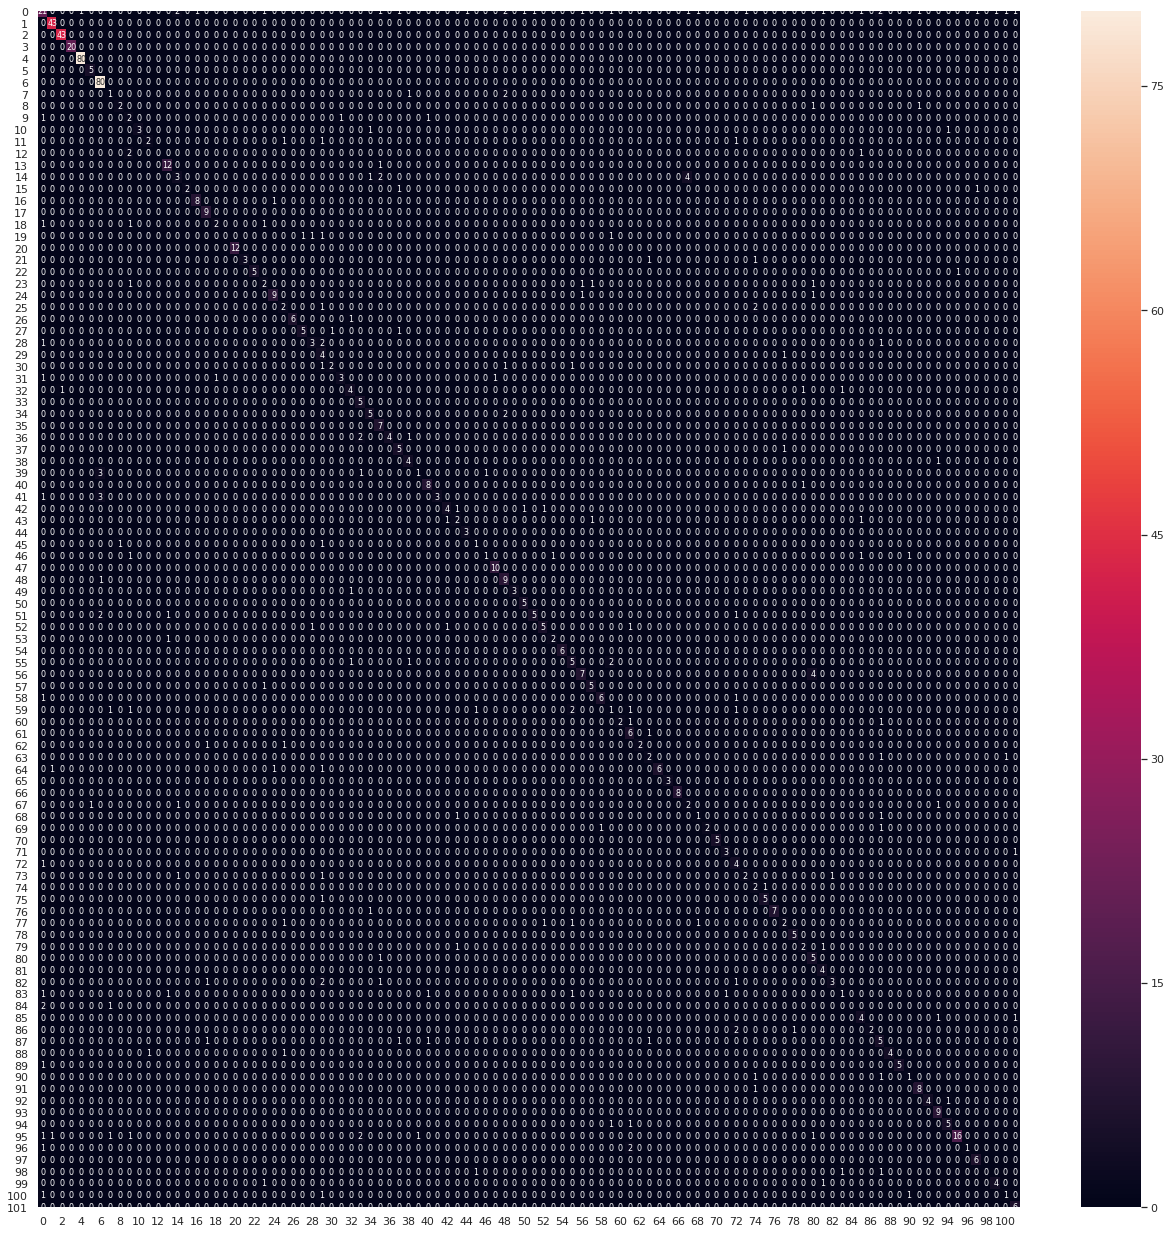

In [0]:
# Matriz de confusión
mat_confusion(model_alpha_5)

In [0]:
# Canviamos el nombre de las capas (para poder visualizar la ultima capa convolucional, en el apartado de predicción)
for i, layer in enumerate(model_alpha_5.layers):
    layer.name = 'layer_' + str(i)

## Predicción

En general (respecto a los 3 modelos) en base a las métricas por clase y a la matriz de confusión, se puede concluir que los modelos aciertan más según que categoría. Las categorías en las que los modelos aciertan más, son aquellas que contienen más imágenes.

### Redes pre-entrenadas

#### Arquitectura VGG19

Imagen del Test Nº 200


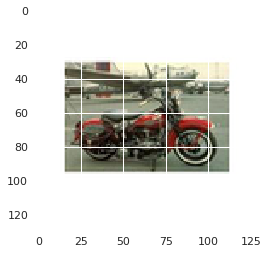

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------


In [0]:
# Predecir la categoria de una imagen en concreto
pred_img(200, model_MobileNetV2_trained)

Imagen del Test Nº 100


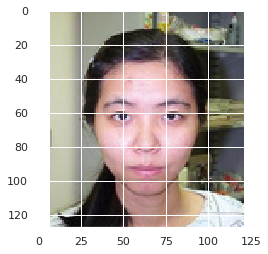

· Categoría Real: Faces_easy
· Categoría Predicha: Faces_easy (100.00 %)
Nº imagenes (Categoría Real): 435
----------------------------------------------
Imagen del Test Nº 200


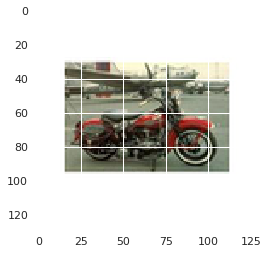

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 300


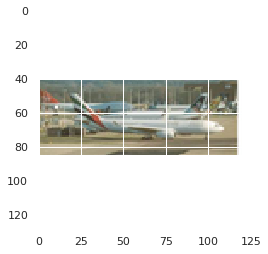

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 400


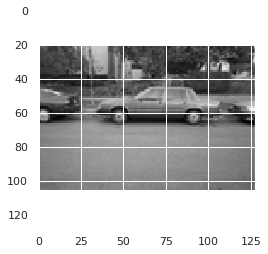

· Categoría Real: car_side
· Categoría Predicha: car_side (99.94 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------
Imagen del Test Nº 500


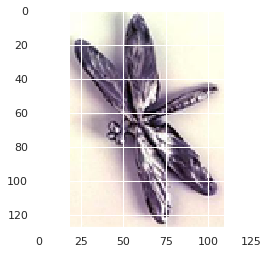

· Categoría Real: dragonfly
· Categoría Predicha: dragonfly (97.67 %)
Nº imagenes (Categoría Real): 68
----------------------------------------------
Imagen del Test Nº 600


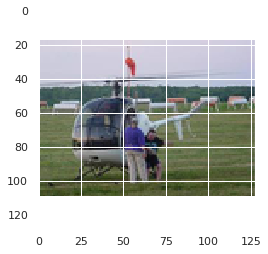

· Categoría Real: helicopter
· Categoría Predicha: helicopter (97.89 %)
Nº imagenes (Categoría Real): 88
----------------------------------------------
Imagen del Test Nº 700


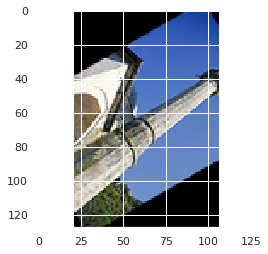

· Categoría Real: minaret
· Categoría Predicha: minaret (99.99 %)
Nº imagenes (Categoría Real): 76
----------------------------------------------
Imagen del Test Nº 800


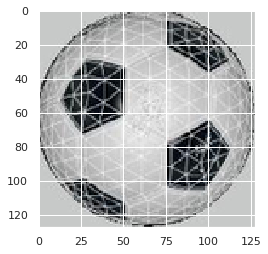

· Categoría Real: soccer_ball
· Categoría Predicha: soccer_ball (99.94 %)
Nº imagenes (Categoría Real): 64
----------------------------------------------
Imagen del Test Nº 900


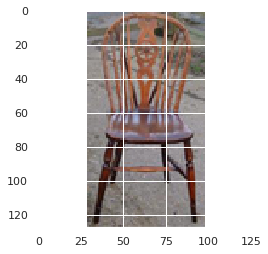

· Categoría Real: windsor_chair
· Categoría Predicha: windsor_chair (51.08 %)
Nº imagenes (Categoría Real): 56
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes
pred_n_img([100,200,300,400,500,600,700,800,900], model_MobileNetV2_trained)

Imagen del Test Nº 84


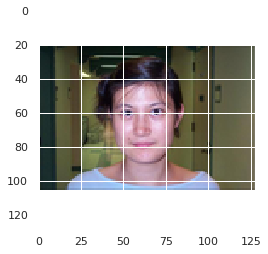

· Categoría Real: Faces
· Categoría Predicha: Faces (99.99 %)
Nº imagenes (Categoría Real): 435
----------------------------------------------
Imagen del Test Nº 514


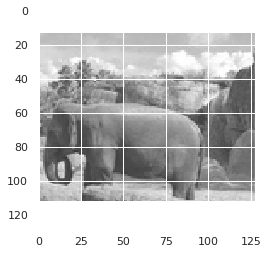

· Categoría Real: elephant
· Categoría Predicha: elephant (40.22 %)
Nº imagenes (Categoría Real): 64
----------------------------------------------
Imagen del Test Nº 681


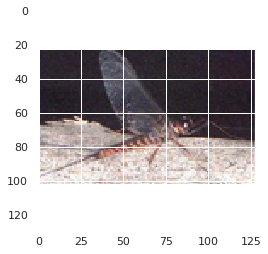

· Categoría Real: mayfly
· Categoría Predicha: mayfly (67.29 %)
Nº imagenes (Categoría Real): 40
----------------------------------------------
Imagen del Test Nº 817


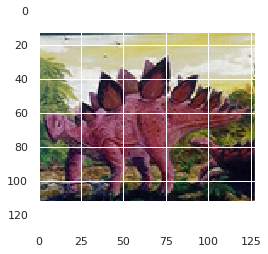

· Categoría Real: stegosaurus
· Categoría Predicha: stegosaurus (98.37 %)
Nº imagenes (Categoría Real): 59
----------------------------------------------
Imagen del Test Nº 562


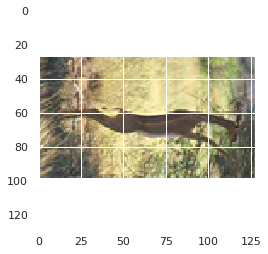

· Categoría Real: gerenuk
· Categoría Predicha: gerenuk (87.58 %)
Nº imagenes (Categoría Real): 34
----------------------------------------------
Imagen del Test Nº 819


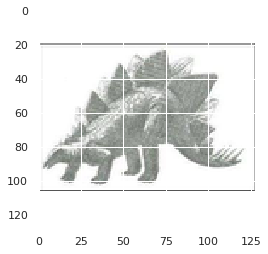

· Categoría Real: stegosaurus
· Categoría Predicha: stegosaurus (98.21 %)
Nº imagenes (Categoría Real): 59
----------------------------------------------
Imagen del Test Nº 690


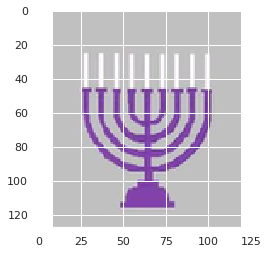

· Categoría Real: menorah
· Categoría Predicha: menorah (100.00 %)
Nº imagenes (Categoría Real): 87
----------------------------------------------
Imagen del Test Nº 751


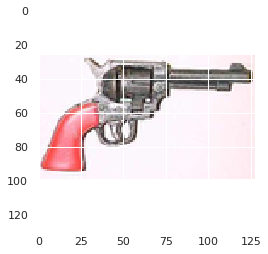

· Categoría Real: revolver
· Categoría Predicha: revolver (100.00 %)
Nº imagenes (Categoría Real): 82
----------------------------------------------
Imagen del Test Nº 681


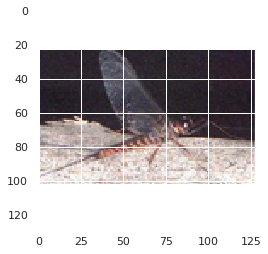

· Categoría Real: mayfly
· Categoría Predicha: mayfly (67.29 %)
Nº imagenes (Categoría Real): 40
----------------------------------------------
Imagen del Test Nº 359


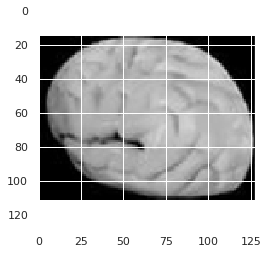

· Categoría Real: brain
· Categoría Predicha: brain (91.65 %)
Nº imagenes (Categoría Real): 98
----------------------------------------------
Imagen del Test Nº 190


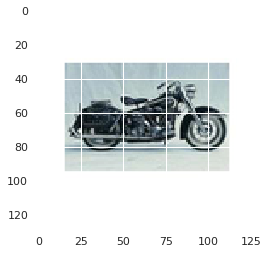

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 290


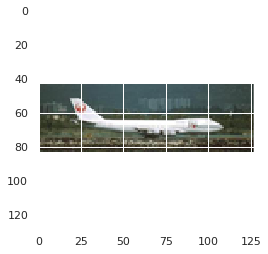

· Categoría Real: airplanes
· Categoría Predicha: airplanes (99.95 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 299


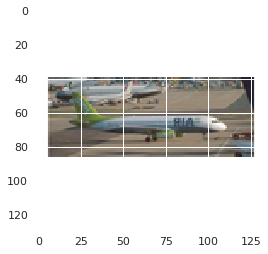

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 400


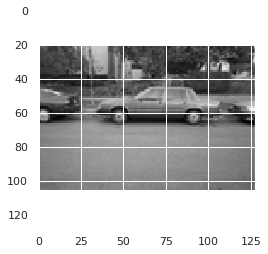

· Categoría Real: car_side
· Categoría Predicha: car_side (99.94 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------
Imagen del Test Nº 385


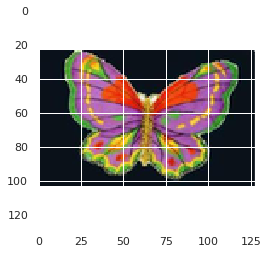

· Categoría Real: butterfly
· Categoría Predicha: butterfly (100.00 %)
Nº imagenes (Categoría Real): 91
----------------------------------------------
Imagen del Test Nº 446


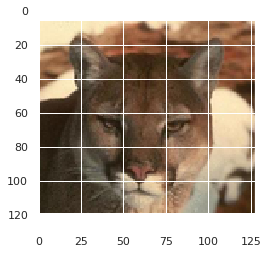

· Categoría Real: cougar_face
· Categoría Predicha: cougar_face (99.65 %)
Nº imagenes (Categoría Real): 69
----------------------------------------------
Imagen del Test Nº 30


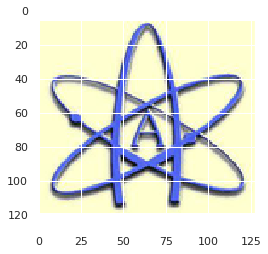

· Categoría Real: BACKGROUND_Google
· Categoría Predicha: cannon (82.74 %)
Nº imagenes (Categoría Real): 468
----------------------------------------------
Imagen del Test Nº 807


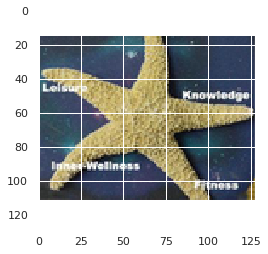

· Categoría Real: starfish
· Categoría Predicha: starfish (99.92 %)
Nº imagenes (Categoría Real): 86
----------------------------------------------
Imagen del Test Nº 161


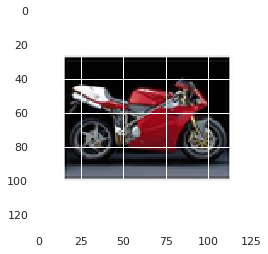

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 404


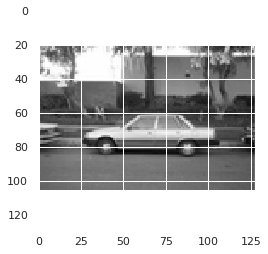

· Categoría Real: car_side
· Categoría Predicha: car_side (99.98 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes random
pred_n_img(20, model_MobileNetV2_trained)

#### Arquitectura MobileNetV2

Imagen del Test Nº 200


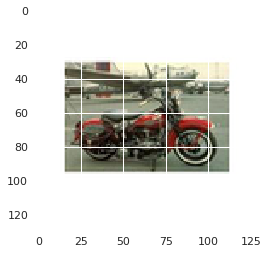

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------


In [0]:
# Predecir la categoria de una imagen en concreto
pred_img(200, model_MobileNetV2_trained)

Imagen del Test Nº 100


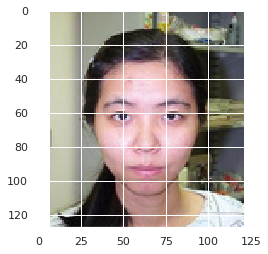

· Categoría Real: Faces_easy
· Categoría Predicha: Faces_easy (100.00 %)
Nº imagenes (Categoría Real): 435
----------------------------------------------
Imagen del Test Nº 200


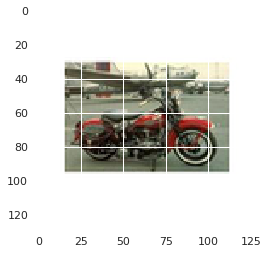

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 300


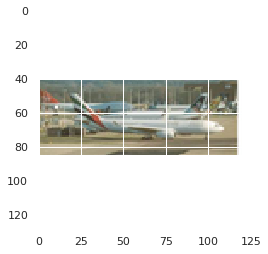

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 400


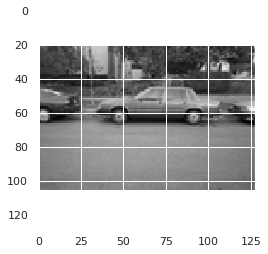

· Categoría Real: car_side
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------
Imagen del Test Nº 500


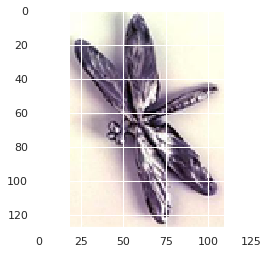

· Categoría Real: dragonfly
· Categoría Predicha: dragonfly (99.81 %)
Nº imagenes (Categoría Real): 68
----------------------------------------------
Imagen del Test Nº 600


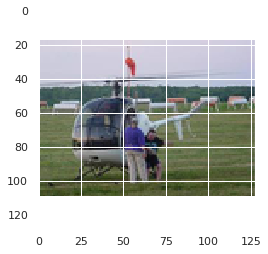

· Categoría Real: helicopter
· Categoría Predicha: helicopter (100.00 %)
Nº imagenes (Categoría Real): 88
----------------------------------------------
Imagen del Test Nº 700


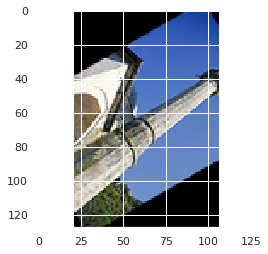

· Categoría Real: minaret
· Categoría Predicha: gerenuk (32.96 %)
Nº imagenes (Categoría Real): 76
----------------------------------------------
Imagen del Test Nº 800


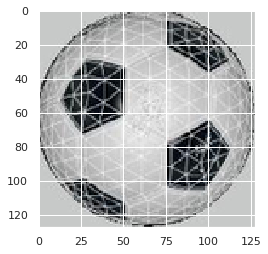

· Categoría Real: soccer_ball
· Categoría Predicha: soccer_ball (100.00 %)
Nº imagenes (Categoría Real): 64
----------------------------------------------
Imagen del Test Nº 900


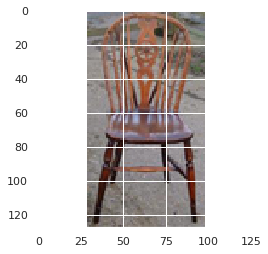

· Categoría Real: windsor_chair
· Categoría Predicha: windsor_chair (99.51 %)
Nº imagenes (Categoría Real): 56
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes
pred_n_img([100,200,300,400,500,600,700,800,900], model_MobileNetV2_trained)

Imagen del Test Nº 630


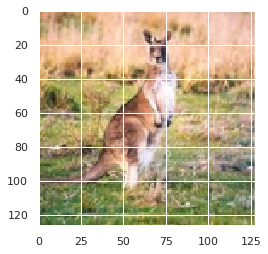

· Categoría Real: kangaroo
· Categoría Predicha: kangaroo (100.00 %)
Nº imagenes (Categoría Real): 86
----------------------------------------------
Imagen del Test Nº 599


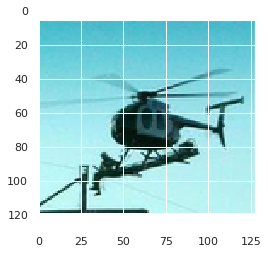

· Categoría Real: helicopter
· Categoría Predicha: helicopter (100.00 %)
Nº imagenes (Categoría Real): 88
----------------------------------------------
Imagen del Test Nº 708


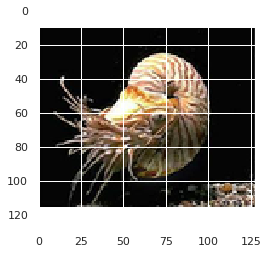

· Categoría Real: nautilus
· Categoría Predicha: nautilus (98.08 %)
Nº imagenes (Categoría Real): 55
----------------------------------------------
Imagen del Test Nº 669


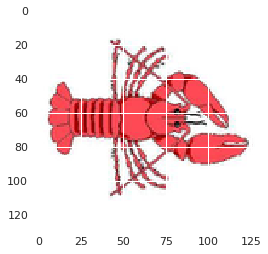

· Categoría Real: lobster
· Categoría Predicha: crayfish (100.00 %)
Nº imagenes (Categoría Real): 41
----------------------------------------------
Imagen del Test Nº 746


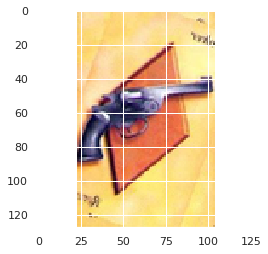

· Categoría Real: revolver
· Categoría Predicha: revolver (100.00 %)
Nº imagenes (Categoría Real): 82
----------------------------------------------
Imagen del Test Nº 691


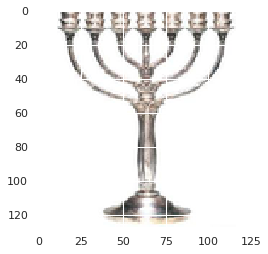

· Categoría Real: menorah
· Categoría Predicha: menorah (99.72 %)
Nº imagenes (Categoría Real): 87
----------------------------------------------
Imagen del Test Nº 721


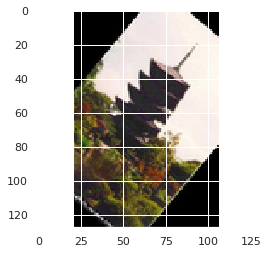

· Categoría Real: pagoda
· Categoría Predicha: minaret (96.02 %)
Nº imagenes (Categoría Real): 47
----------------------------------------------
Imagen del Test Nº 424


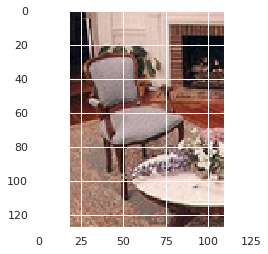

· Categoría Real: chair
· Categoría Predicha: chair (100.00 %)
Nº imagenes (Categoría Real): 62
----------------------------------------------
Imagen del Test Nº 897


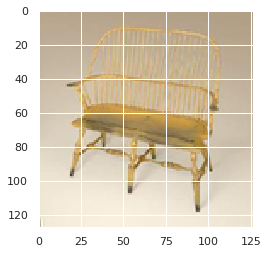

· Categoría Real: windsor_chair
· Categoría Predicha: chair (95.49 %)
Nº imagenes (Categoría Real): 56
----------------------------------------------
Imagen del Test Nº 227


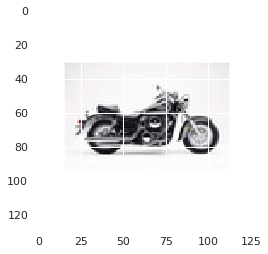

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 324


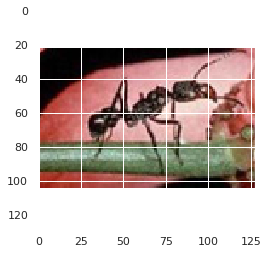

· Categoría Real: ant
· Categoría Predicha: revolver (96.67 %)
Nº imagenes (Categoría Real): 42
----------------------------------------------
Imagen del Test Nº 351


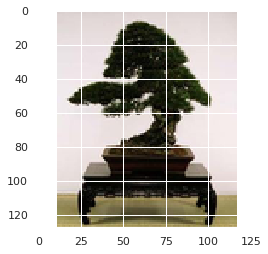

· Categoría Real: bonsai
· Categoría Predicha: bonsai (100.00 %)
Nº imagenes (Categoría Real): 128
----------------------------------------------
Imagen del Test Nº 338


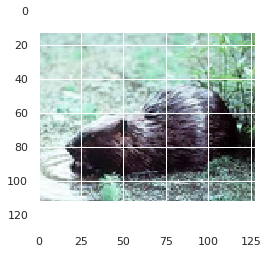

· Categoría Real: beaver
· Categoría Predicha: chandelier (96.74 %)
Nº imagenes (Categoría Real): 46
----------------------------------------------
Imagen del Test Nº 629


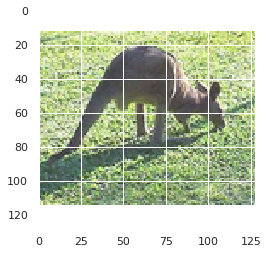

· Categoría Real: kangaroo
· Categoría Predicha: rhino (77.54 %)
Nº imagenes (Categoría Real): 86
----------------------------------------------
Imagen del Test Nº 572


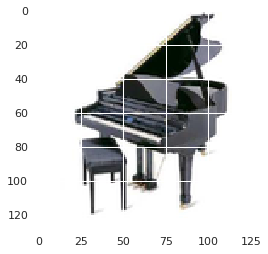

· Categoría Real: grand_piano
· Categoría Predicha: grand_piano (100.00 %)
Nº imagenes (Categoría Real): 99
----------------------------------------------
Imagen del Test Nº 259


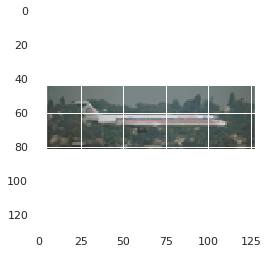

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 239


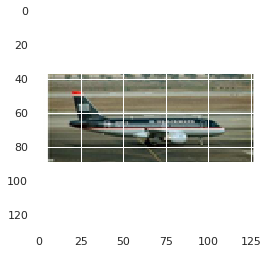

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 188


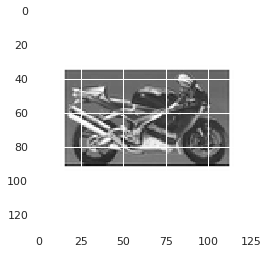

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (100.00 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 649


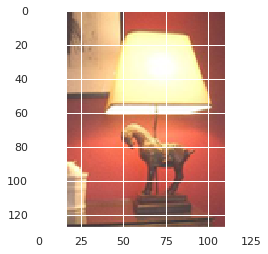

· Categoría Real: lamp
· Categoría Predicha: lamp (100.00 %)
Nº imagenes (Categoría Real): 61
----------------------------------------------
Imagen del Test Nº 725


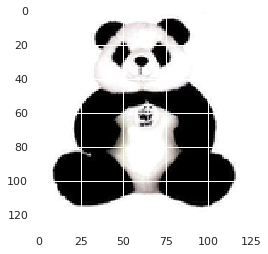

· Categoría Real: panda
· Categoría Predicha: panda (49.16 %)
Nº imagenes (Categoría Real): 38
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes random
pred_n_img(20, model_MobileNetV2_trained)

### Red desde cero (model alpha_5)

Imagen del Test Nº 200
· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (99.99 %)
Nº imagenes (Categoría Real): 798


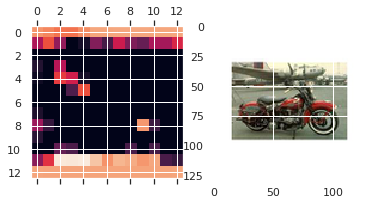

In [0]:
# Predecir la categoria de una imagen en concreto
pred_img_2(200, model_alpha_5)

Imagen del Test Nº 100


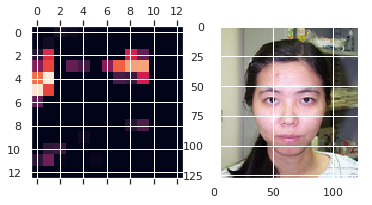

· Categoría Real: Faces_easy
· Categoría Predicha: Faces_easy (100.00 %)
Nº imagenes (Categoría Real): 435
----------------------------------------------
Imagen del Test Nº 200


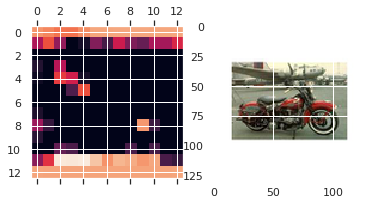

· Categoría Real: Motorbikes
· Categoría Predicha: Motorbikes (99.99 %)
Nº imagenes (Categoría Real): 798
----------------------------------------------
Imagen del Test Nº 300


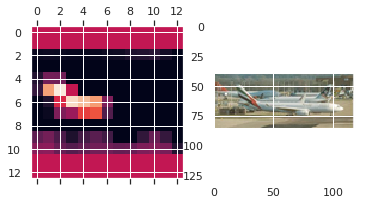

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 400


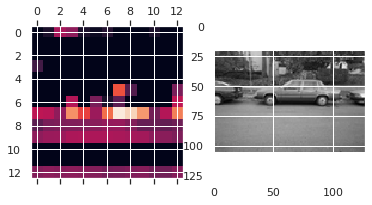

· Categoría Real: car_side
· Categoría Predicha: car_side (99.98 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------
Imagen del Test Nº 500


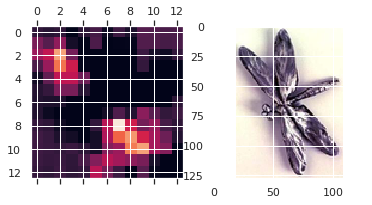

· Categoría Real: dragonfly
· Categoría Predicha: dragonfly (73.06 %)
Nº imagenes (Categoría Real): 68
----------------------------------------------
Imagen del Test Nº 600


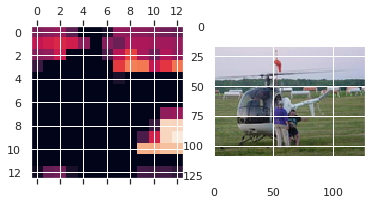

· Categoría Real: helicopter
· Categoría Predicha: helicopter (55.80 %)
Nº imagenes (Categoría Real): 88
----------------------------------------------
Imagen del Test Nº 700


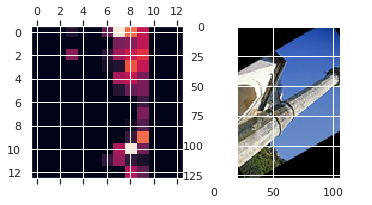

· Categoría Real: minaret
· Categoría Predicha: minaret (99.80 %)
Nº imagenes (Categoría Real): 76
----------------------------------------------
Imagen del Test Nº 800


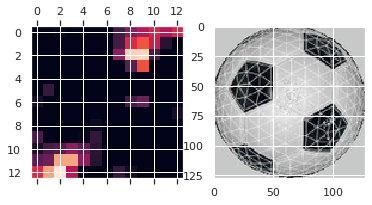

· Categoría Real: soccer_ball
· Categoría Predicha: soccer_ball (34.92 %)
Nº imagenes (Categoría Real): 64
----------------------------------------------
Imagen del Test Nº 900


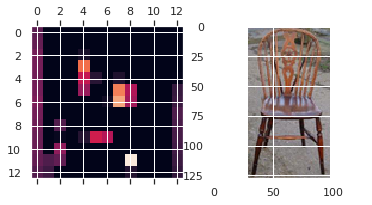

· Categoría Real: windsor_chair
· Categoría Predicha: windsor_chair (99.30 %)
Nº imagenes (Categoría Real): 56
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes
pred_n_img_2([100,200,300,400,500,600,700,800,900], model_alpha_5)

Imagen del Test Nº 733


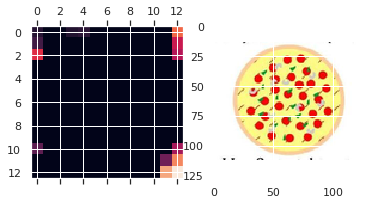

· Categoría Real: pizza
· Categoría Predicha: brain (55.59 %)
Nº imagenes (Categoría Real): 53
----------------------------------------------
Imagen del Test Nº 45


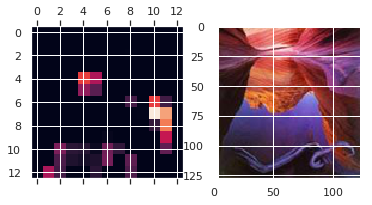

· Categoría Real: BACKGROUND_Google
· Categoría Predicha: brain (19.00 %)
Nº imagenes (Categoría Real): 468
----------------------------------------------
Imagen del Test Nº 128


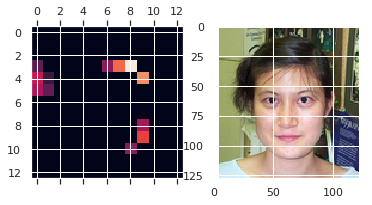

· Categoría Real: Faces_easy
· Categoría Predicha: Faces_easy (100.00 %)
Nº imagenes (Categoría Real): 435
----------------------------------------------
Imagen del Test Nº 422


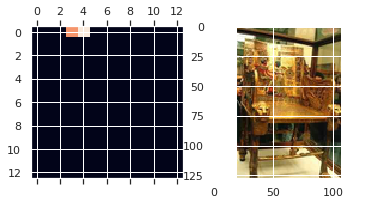

· Categoría Real: chair
· Categoría Predicha: barrel (42.82 %)
Nº imagenes (Categoría Real): 62
----------------------------------------------
Imagen del Test Nº 761


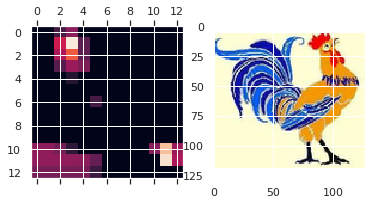

· Categoría Real: rooster
· Categoría Predicha: rooster (99.93 %)
Nº imagenes (Categoría Real): 49
----------------------------------------------
Imagen del Test Nº 556


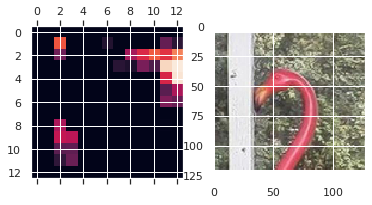

· Categoría Real: flamingo_head
· Categoría Predicha: flamingo (30.36 %)
Nº imagenes (Categoría Real): 45
----------------------------------------------
Imagen del Test Nº 785


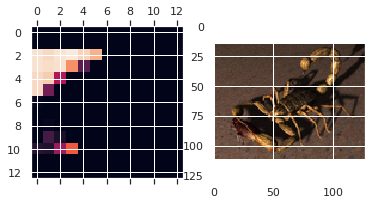

· Categoría Real: scorpion
· Categoría Predicha: scorpion (51.42 %)
Nº imagenes (Categoría Real): 84
----------------------------------------------
Imagen del Test Nº 735


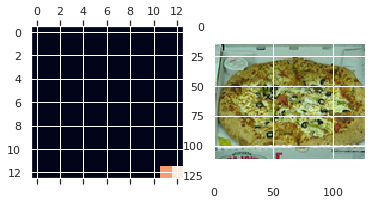

· Categoría Real: pizza
· Categoría Predicha: crocodile (13.81 %)
Nº imagenes (Categoría Real): 53
----------------------------------------------
Imagen del Test Nº 587


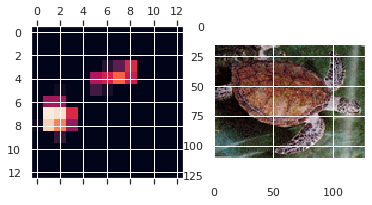

· Categoría Real: hawksbill
· Categoría Predicha: hawksbill (49.93 %)
Nº imagenes (Categoría Real): 100
----------------------------------------------
Imagen del Test Nº 598


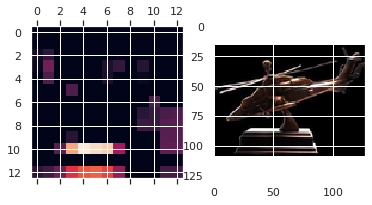

· Categoría Real: helicopter
· Categoría Predicha: bonsai (36.49 %)
Nº imagenes (Categoría Real): 88
----------------------------------------------
Imagen del Test Nº 911


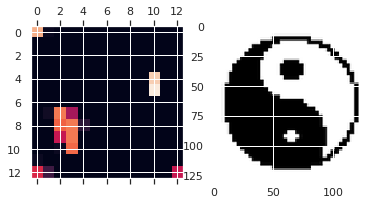

· Categoría Real: yin_yang
· Categoría Predicha: yin_yang (99.84 %)
Nº imagenes (Categoría Real): 60
----------------------------------------------
Imagen del Test Nº 479


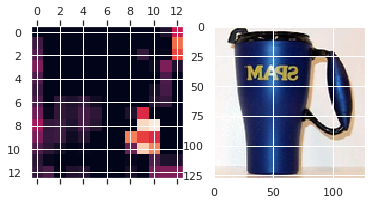

· Categoría Real: cup
· Categoría Predicha: camera (13.99 %)
Nº imagenes (Categoría Real): 57
----------------------------------------------
Imagen del Test Nº 45


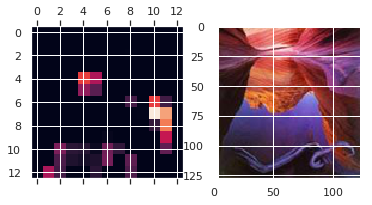

· Categoría Real: BACKGROUND_Google
· Categoría Predicha: brain (19.00 %)
Nº imagenes (Categoría Real): 468
----------------------------------------------
Imagen del Test Nº 316


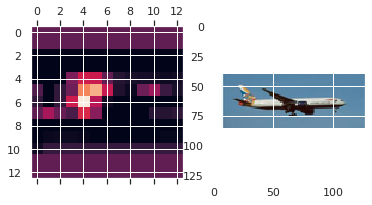

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 636


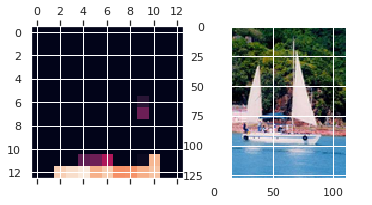

· Categoría Real: ketch
· Categoría Predicha: ketch (52.21 %)
Nº imagenes (Categoría Real): 114
----------------------------------------------
Imagen del Test Nº 381


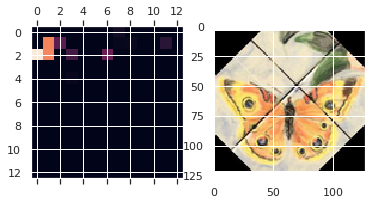

· Categoría Real: butterfly
· Categoría Predicha: butterfly (99.16 %)
Nº imagenes (Categoría Real): 91
----------------------------------------------
Imagen del Test Nº 424


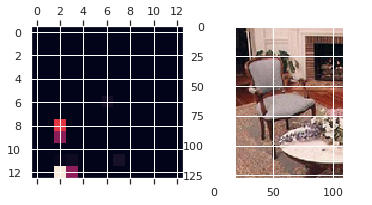

· Categoría Real: chair
· Categoría Predicha: chair (95.22 %)
Nº imagenes (Categoría Real): 62
----------------------------------------------
Imagen del Test Nº 262


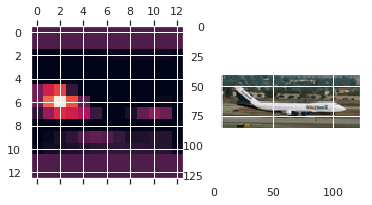

· Categoría Real: airplanes
· Categoría Predicha: airplanes (100.00 %)
Nº imagenes (Categoría Real): 800
----------------------------------------------
Imagen del Test Nº 404


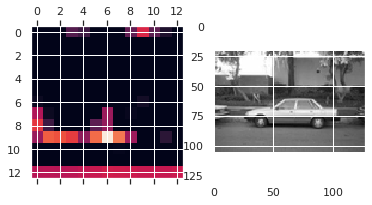

· Categoría Real: car_side
· Categoría Predicha: car_side (100.00 %)
Nº imagenes (Categoría Real): 123
----------------------------------------------
Imagen del Test Nº 376


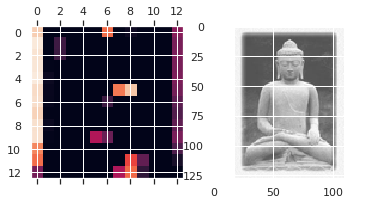

· Categoría Real: buddha
· Categoría Predicha: buddha (85.69 %)
Nº imagenes (Categoría Real): 85
----------------------------------------------


In [0]:
# Predecir la categoria de un conjunto de imagenes random
pred_n_img_2(20, model_alpha_5)